In [9]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical


In [10]:
import pandas as pd
import numpy as np

def clean_numeric_df(df, target_column='label'):
    """
    Quick data cleaning for immediate use with infinite value handling
    """
    df_clean = df.copy()
    
    # 1. Remove duplicates
    df_clean = df_clean.drop_duplicates()
    
    # 2. Handle infinite values in numeric columns
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if np.any(np.isinf(df_clean[col])):
            # Replace inf/-inf with NaN first
            df_clean[col] = df_clean[col].replace([np.inf, -np.inf], np.nan)
    
    # 3. Handle missing values strategically (including those from inf replacement)
    for col in df_clean.columns:
        if df_clean[col].isnull().sum() > 0:
            if df_clean[col].dtype in ['int64', 'float64']:
                # For numeric: use median if skewed, mean otherwise
                if abs(df_clean[col].skew()) > 1:
                    df_clean[col].fillna(df_clean[col].median(), inplace=True)
                else:
                    df_clean[col].fillna(df_clean[col].mean(), inplace=True)
            else:
                # For categorical: use mode
                df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)
    
    # 4. Handle outliers using IQR capping
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
    if target_column in numeric_cols:
        numeric_cols = numeric_cols.drop(target_column)
    
    for col in numeric_cols:
        Q1, Q3 = df_clean[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
        df_clean[col] = np.clip(df_clean[col], lower, upper)
    
    return df_clean

In [11]:
set_a_features = [
    # Flow time & rate features
    'Flow Duration', 'Flow Byts/s', 'Flow Pkts/s',
    'Fwd Pkts/s', 'Bwd Pkts/s',

  # Inter-arrival times
    'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
    'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
    'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Bwd IAT Tot', 'Fwd IAT Tot',

    # Packet size stats (for temporal variance)
    'Pkt Len Mean', 'Pkt Len Std', 'Pkt Size Avg',

    # Active/Idle patterns (C&C periodic behaviour)
    'Active Mean', 'Idle Mean',

    # Subflow dynamics (important for Neris/Rbot)
    'Subflow Fwd Byts', 'Subflow Bwd Byts'
]
set_b_features = [
    # Protocol and ports
    'Protocol',

    # Flag-based patterns
    'SYN Flag Cnt', 'ACK Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'FIN Flag Cnt',

    # Flow-level packet stats
    'Flow Duration', 'Flow Byts/s', 'Flow Pkts/s',
    'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Max', 'Pkt Len Min',

    # Header and ratio cues
    'Fwd Header Len', 'Bwd Header Len', 'Down/Up Ratio'
]
set_a_b=[ # Flow time & rate features
    'Flow Duration', 'Flow Byts/s', 'Flow Pkts/s',
    'Fwd Pkts/s', 'Bwd Pkts/s',

  # Inter-arrival times
    'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
    'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
    'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Bwd IAT Tot', 'Fwd IAT Tot',

    # Packet size stats (for temporal variance)
    'Pkt Len Mean', 'Pkt Len Std', 'Pkt Size Avg',

    # Active/Idle patterns (C&C periodic behaviour)
    'Active Mean', 'Idle Mean',

    # Subflow dynamics (important for Neris/Rbot)
    'Subflow Fwd Byts', 'Subflow Bwd Byts'
     # Protocol and ports
    'Protocol',

    # Flag-based patterns
    'SYN Flag Cnt', 'ACK Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'FIN Flag Cnt',

    'Pkt Len Max', 'Pkt Len Min',

    # Header and ratio cues
    'Fwd Header Len', 'Bwd Header Len', 'Down/Up Ratio'
]



In [12]:
import pandas as pd
selected_features=[]

def ensure_features(df: pd.DataFrame,req_set) -> pd.DataFrame:
    for val in req_set:
        if val.upper() == "A":
            for feats in set_a_features:
                if feats not in df:
                    df[f"{feats}"]=0
        elif val.upper() == "B":
             for feats in set_b_features:
                if feats not in df:
                    df[f"{feats}"]=0
        else:
            raise ValueError("Invalid set_type. Use 'A' for LSTM/CNN or 'B' for Random Forest.")
    return df

def get_feature_set(df: pd.DataFrame, set_list) -> pd.DataFrame:
    for val in set_list:
        if val.upper() == "A":
            for feats in set_a_features:
                if feats not in selected_features:
                    selected_features.append(feats)
        elif val.upper() == "B":
             for feats in set_b_features:
                if feats not in selected_features:
                    selected_features.append(feats)
        else:
            raise ValueError("Invalid set_type. Use 'A' for LSTM/CNN or 'B' for Random Forest.")
            
        
    return df[selected_features].copy()


def features_union(set_list):
    dummy_list=[]
    for val in set_list:
        if val.upper() == "A":
            for feats in set_a_features:
                if feats not in dummy_list:
                    dummy_list.append(feats)
        elif val.upper() == "B":
             for feats in set_b_features:
                if feats not in dummy_list:
                    dummy_list.append(feats)
    return dummy_list

# ----------------------------

def process_file(file_path: str, set_list) -> pd.DataFrame:
    df = pd.read_csv(file_path)
    df=ensure_features(df,set_list)
    filtered_df = get_feature_set(df, set_list)
    df=clean_numeric_df(filtered_df)
    return df



# def clean_numeric_df(df):
#     df_clean = df.copy()
    
#     numeric_cols = [col for col in df_clean.columns if col not in ['label', 'label_ori']]
#     for col in numeric_cols:
#         df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

#     df_clean[numeric_cols] = df_clean[numeric_cols].replace([np.inf, -np.inf], np.nan).fillna(0)
    
#     return df_clean



In [13]:
df_normal=process_file("D:\\Downloads\\benign.csv",['A','B'])
train_layer_1, test_layer_1 = train_test_split(
    df_normal,
    test_size=0.2,        
    random_state=42,      
    shuffle=True,
)
test_layer_1["label"] = "benign"


df_zero=process_file("D:\\Downloads\\sogou.csv",['A','B'])
alpha, test_new = train_test_split(
    df_zero,
    test_size=0.95,        
    random_state=42,      
    shuffle=True,
)
test_layer_1["label"] = "benign"
test_new["label"] = "sogou"


In [14]:
df_attack=[]
folder_path ="C:\\Users\\korad\\Downloads\\attacks_file\\csv_output"
for file_path in os.listdir(folder_path):
    full_path = os.path.join(folder_path, file_path)
    file_name = os.path.splitext(file_path)[0].lower() 
    attack_name = file_name.split('_')[0]
    df = process_file(full_path, ['A', 'B'])
    df['label_ori'] = attack_name
    df_attack.append(df)
df_attack=pd.concat(df_attack,ignore_index=True)
df_attack=clean_numeric_df(df_attack)

In [15]:

df_attack_layer_2 = df_attack.copy()


df_attack_layer_2["label"] = df_attack_layer_2["label_ori"].apply(
    lambda x: "neris" if "neris" in x else
              "rbot" if "rbot" in x else
              "other"
)


train_layer_2, test_layer_2 = train_test_split(
    df_attack_layer_2,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=df_attack_layer_2["label"]
)

train_layer_2_A = train_layer_2[set_a_features + ['label']].copy()
test_layer_2 = test_layer_2.drop(columns=['label']).rename(columns={'label_ori': 'label'})
train_layer_2_AB = train_layer_2.drop(columns=['label_ori'])


In [16]:
df_attack_layer_3=[]   # only set b features
for file_path in os.listdir(folder_path):
    full_path = os.path.join(folder_path, file_path)
    file_name = os.path.splitext(file_path)[0]  
    df = process_file(full_path, ['A','B'])  
    if file_name == "menti":
        df["label"] = "menti"
        df_attack_layer_3.append(df)
    elif file_name=="murlo":
        df["label"] = "murlo"
        df_attack_layer_3.append(df)
    elif file_name=="nsisay":
        df["label"] = "nsisay"
        df_attack_layer_3.append(df)
    elif file_name in ["virut", "virut_2"]:
        df["label"] = "virut"
        df_attack_layer_3.append(df)
    
df_attack_layer_3 = pd.concat(df_attack_layer_3, ignore_index=True)
df_attack_layer_3=clean_numeric_df(df_attack_layer_3)

train_layer_3, test_layer_3 = train_test_split(
    df_attack_layer_3,
    test_size=0.2,       
    random_state=42,     
    shuffle=True,
    stratify=df_attack_layer_3["label"] 
)
train_layer_3_B = train_layer_3[set_b_features + ['label']].copy()
train_layer_3_AB = train_layer_3

In [17]:
train_layer_4=[]
for file_path in os.listdir(folder_path):
    full_path = os.path.join(folder_path, file_path)
    file_name = os.path.splitext(file_path)[0]  # get file name without extension
    df = process_file(full_path, ['A','B'])  # process the file
    if file_name == "menti":
        df["label"] = "menti"
        train_layer_4.append(df)
    elif file_name=="murlo":
        df["label"] = "murlo"
        train_layer_4.append(df)
    elif file_name=="nsisay":
        df["label"] = "nsisay"
        train_layer_4.append(df)
    elif file_name in ["virut", "virut_2"]:
        df["label"] = "virut"
        train_layer_4.append(df)
    
train_layer_4 = pd.concat(train_layer_4, ignore_index=True)
train_layer_4=clean_numeric_df(train_layer_4)



In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import StandardScaler
import numpy as np


##----------------------------layer_1_train---------------------------


def build_autoencoder(input_dim, latent_dim=10):
    # Encoder
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.Dense(32, activation='relu')(x)
    latent = layers.Dense(latent_dim, activation='relu', name="latent")(x)

    # Decoder
    d = layers.Dense(32, activation='relu')(latent)
    d = layers.Dense(64, activation='relu')(d)
    outputs = layers.Dense(input_dim, activation='linear')(d)

    # Model
    autoencoder = models.Model(inputs, outputs)
    autoencoder.compile(optimizer='adam', loss='mse')

    # Decoder model (for reconstruction)
    decoder = models.Model(
        inputs=latent,
        outputs=outputs
    )

    return autoencoder, decoder

def train_layer1_autoencoder(df, latent_dim=10):
    numeric_df = df.select_dtypes(include=[np.number])
    input_dim = numeric_df.shape[1]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(numeric_df)

    autoencoder, decoder = build_autoencoder(input_dim, latent_dim)

    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_schedule = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
    checkpoint = callbacks.ModelCheckpoint('autoencoder_layer1_best.keras', monitor='val_loss', save_best_only=True)

    print("🚀 Training Autoencoder Layer 1...")
    history = autoencoder.fit(
        X_scaled, X_scaled,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stop, lr_schedule, checkpoint],
        verbose=1
    )

    reconstructed = autoencoder.predict(X_scaled, verbose=0)
    errors = np.mean(np.square(X_scaled - reconstructed), axis=1)

    return autoencoder, decoder, scaler, history, errors
vae_layer1, decoder_layer1, scaler_layer1, hist_layer1, recon_errors = train_layer1_autoencoder(train_layer_1)

🚀 Training Autoencoder Layer 1...
Epoch 1/50
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.1707 - val_loss: 0.0143 - learning_rate: 0.0010
Epoch 2/50
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0120 - val_loss: 0.0077 - learning_rate: 0.0010
Epoch 3/50
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0069 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 4/50
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0054 - val_loss: 0.0046 - learning_rate: 0.0010
Epoch 5/50
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0044 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 6/50
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0037 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 7/50
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0033 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 8/50
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0031 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 9/50
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0028 -

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np


##----------------------------layer_1_predict---------------------------


def detect_attacks_layer1(test, vae_model, scaler, threshold=0.1):
    test_df = test.select_dtypes(include=[np.number])
    X_test_scaled = scaler.transform(test_df)

    # Reconstructions
    reconstructions = vae_model.predict(X_test_scaled)

    # MAE reconstruction error
    mae = np.mean(np.abs(X_test_scaled - reconstructions), axis=1)

    # Attack = 1, Benign = 0
    y_pred = (mae > threshold).astype(int)

    # Ground truth (benign = 0, attack = 1)
    if "label" not in test.columns:
        print("No labels found, cannot compute metrics.")
        return None, mae
    
    true_labels = test["label"]
    y_true = (~true_labels.str.contains("benign", case=False, na=False)).astype(int)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # ROC AUC (works for binary classification)
    try:
        roc = roc_auc_score(y_true, mae)
    except:
        roc = float('nan')

    # Print with 6-decimal formatting
    print("\nCONFUSION MATRIX (rows=true, cols=pred):")
    print(cm)

    print(f"\nAccuracy : {acc:.6f}")
    print(f"Precision: {prec:.6f}")
    print(f"Recall   : {rec:.6f}")
    print(f"F1-Score : {f1:.6f}")
    print(f"ROC-AUC  : {roc:.6f}")

    attack_mask = mae > threshold
    attack_df = test[attack_mask].copy()

    return attack_df

In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

def train_layer2_model_sparse(df_attack_layer_2, epochs=50, batch_size=32, verbose=1):
   
   
    """
    CNN -> LSTM architecture:
    - Conv1D layers run over the feature axis (features treated as timesteps)
    - Their per-timestep outputs (filters) form a sequence that the LSTM consumes
    Returns: model, scaler, label_encoder, history
    """


    # Label encoding
    label_encoder = LabelEncoder()
    df_attack_layer_2 = df_attack_layer_2.copy()
    df_attack_layer_2["label_encoded"] = label_encoder.fit_transform(df_attack_layer_2["label"])

    X = df_attack_layer_2.drop(["label", "label_encoded"], axis=1).values.astype(np.float64)
    y = df_attack_layer_2["label_encoded"].values.astype(np.int32)
    num_classes = len(label_encoder.classes_)

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Reshape so features = timesteps, channels = 1
    # Shape -> (samples, timesteps=num_features, channels=1)
    X_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

    timesteps = X_reshaped.shape[1]    # = num_features
    channels = X_reshaped.shape[2]     # = 1

    inputs = layers.Input(shape=(timesteps, channels))

    # ---- CNN block (extract local patterns across neighboring features) ----
    # Use padding='same' so sequence length remains timesteps.
    x = layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    # Optionally add a bottleneck / projection to reduce channels
    x = layers.Conv1D(filters=32, kernel_size=1, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    # x has shape (timesteps, filters) = (num_features, 32)

    # ---- LSTM block (consume the per-timestep feature vectors produced by CNN) ----
    # Bidirectional LSTM reads the sequence of CNN features
    lstm_out = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(x)
    lstm_out = layers.BatchNormalization()(lstm_out)

    # ---- Classifier head ----
    combined = layers.Dense(64, activation='relu')(lstm_out)
    combined = layers.Dropout(0.4)(combined)
    combined = layers.Dense(32, activation='relu')(combined)
    combined = layers.Dropout(0.2)(combined)
    outputs = layers.Dense(num_classes, activation='softmax')(combined)

    model = Model(inputs, outputs)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    print("Training Layer 2 (CNN -> Bidirectional LSTM) with labels:", list(label_encoder.classes_))

    es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)

    history = model.fit(
        X_reshaped, y,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[es],
        verbose=verbose
    )

    return model, scaler, label_encoder


###verified by passing A,AB got AB as more ...


layer2_model_A, scaler_layer_2_A, label_encoder_layer2_A = train_layer2_model_sparse(train_layer_2_A)
layer2_model_AB, scaler_layer_2_AB, label_encoder_layer2_AB = train_layer2_model_sparse(train_layer_2_AB)


Training Layer 2 (CNN -> Bidirectional LSTM) with labels: ['neris', 'other', 'rbot']
Epoch 1/50
2980/2980 ━━━━━━━━━━━━━━━━━━━━ 45s 14ms/step - accuracy: 0.8700 - loss: 0.3350 - val_accuracy: 0.9407 - val_loss: 0.1649
Epoch 2/50
2980/2980 ━━━━━━━━━━━━━━━━━━━━ 47s 16ms/step - accuracy: 0.9393 - loss: 0.1668 - val_accuracy: 0.9530 - val_loss: 0.1333
Epoch 3/50
2980/2980 ━━━━━━━━━━━━━━━━━━━━ 52s 18ms/step - accuracy: 0.9476 - loss: 0.1438 - val_accuracy: 0.9495 - val_loss: 0.1344
Epoch 4/50
2980/2980 ━━━━━━━━━━━━━━━━━━━━ 56s 19ms/step - accuracy: 0.9501 - loss: 0.1380 - val_accuracy: 0.9557 - val_loss: 0.1181
Epoch 5/50
2980/2980 ━━━━━━━━━━━━━━━━━━━━ 55s 18ms/step - accuracy: 0.9519 - loss: 0.1331 - val_accuracy: 0.9561 - val_loss: 0.1176
Epoch 6/50
2980/2980 ━━━━━━━━━━━━━━━━━━━━ 47s 16ms/step - accuracy: 0.9535 - loss: 0.1247 - val_accuracy: 0.9585 - val_loss: 0.1130
Epoch 7/50
2980/2980 ━━━━━━━━━━━━━━━━━━━━ 44s 15ms/step - accuracy: 0.9552 - loss: 0.1219 - val_accuracy: 0.9574 - val_loss

In [ ]:
counts = train_layer_2['label'].value_counts()
percentages = train_layer_2['label'].value_counts(normalize=True) * 100
pd.DataFrame({'Count': counts, 'Percentage': percentages})

,Count,Percentage
other,46208,38.774209
neris,37149,31.172591
rbot,35815,30.053200


In [ ]:

def predict_layer2_model(model, scaler, label_encoder, data,
                         feats_list):

    df = data.copy()
    feature_cols=features_union(feats_list)
    # ========= TEMP MAPPING (neris / rbot / other) =========
    df["label_layer2_temp"] = df["label"].apply(
        lambda x: "neris" if "neris" in x else
                  "rbot" if "rbot" in x else
                  "other"
    )

    # ========= FEATURE COLUMNS =========
    # ========= FEATURE SCALING =========
    X_scaled = scaler.transform(df[feature_cols])

    # ========= RESHAPE FOR SEQ MODEL =========
    X_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

    # ========= MODEL PREDICTION =========
    predictions = model.predict(X_reshaped, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    predicted_labels = label_encoder.inverse_transform(predicted_classes)

    df["Predicted_Class"] = predicted_labels

    # ========= TRUE LABELS =========
    true_y = df["label_layer2_temp"]

    # ========= CONFUSION MATRIX =========
    labels = ["neris", "rbot", "other"]
    cm = confusion_matrix(true_y, predicted_labels, labels=labels)
    cm_df = pd.DataFrame(
        cm,
        index=[f"True_{l}" for l in labels],
        columns=[f"Pred_{l}" for l in labels]
    )

    # ========= CORE METRICS =========
    accuracy_argmax = accuracy_score(true_y, predicted_labels)
    class_report = classification_report(true_y, predicted_labels, labels=labels, output_dict=True)

    # Extract precision, recall, f1
    precision = {k: class_report[k]["precision"] for k in labels}
    recall = {k: class_report[k]["recall"] for k in labels}
    f1 = {k: class_report[k]["f1-score"] for k in labels}

    macro_f1 = class_report["macro avg"]["f1-score"]
    weighted_f1 = class_report["weighted avg"]["f1-score"]

    # ========= Custom Botnet Metrics =========

    # Detection rate (recall of botnets)
    DR_neris = recall["neris"]
    DR_rbot = recall["rbot"]

    # False alarm rate = predicted botnet but actually other
    false_neris = cm[2][0]  # True other, predicted neris
    false_rbot = cm[2][1]   # True other, predicted rbot
    total_normal = cm[2].sum()

    FAR = (false_neris + false_rbot) / total_normal if total_normal > 0 else 0

    # ========= PRINT ANALYSIS =========
    print("="*75)
    print("🔍 LAYER 2 BOTNET DETECTION — METRICS SUMMARY")
    print("="*75)

    print("\n📊 Confusion Matrix:")
    print(cm_df)
    

    print("\n📌 Overall Accuracy:", round(accuracy_argmax, 4))

    print("\n--- CLASS-WISE METRICS ---")
    for cls in labels:
        print(f"\nClass: {cls}")
        print(f" Precision: {precision[cls]:.4f}")
        print(f" Recall (Detection Rate): {recall[cls]:.4f}")
        print(f" F1-Score: {f1[cls]:.4f}")

    print("\n📌 Macro F1:", round(macro_f1, 4))
    print("📌 Weighted F1:", round(weighted_f1, 4))

    print("\n--- BOTNET-SPECIFIC METRICS ---")
    print(f"🔸 Detection Rate (Neris): {DR_neris:.4f}")
    print(f"🔸 Detection Rate (Rbot): {DR_rbot:.4f}")
    print(f"🔸 False Alarm Rate (FAR): {FAR:.4f}")

    # ========= ROUTE TO LAYER 3 =========
    df_layer3 = df[df["Predicted_Class"] == "other"].copy()
    df_layer3 = df_layer3.drop(columns=["label_layer2_temp"])

    return df_layer3


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import numpy as np

def train_layer3_rf(df_attack):
    # Ensure the features exist
    feature_cols = [
        col for col in df_attack.columns 
        if col not in ["label"] 
    ]
    
    # Select features
    X = df_attack[feature_cols].copy()

    # Encode labels
    le = LabelEncoder()
    y = le.fit_transform(df_attack['label'])
    print("Original labels:", np.unique(y))
    
    # Train Random Forest
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X, y)
    
    print(f"Trained Layer 3 RF on {len(df_attack)} samples, {len(feature_cols)} features")
    print(f"Classes: {list(le.classes_)}")
    
    return rf_model, le

# Usage
rf_layer3_B, label_encoder_layer3_B = train_layer3_rf(train_layer_3_B)
rf_layer3_AB, label_encoder_layer3_AB = train_layer3_rf(train_layer_3_AB)
# print("Original labels:", np.unique(df_attack_layer_3['label']))



Original labels: [0 1 2 3]
Trained Layer 3 RF on 46208 samples, 16 features
Classes: ['menti', 'murlo', 'nsisay', 'virut']
Original labels: [0 1 2 3]
Trained Layer 3 RF on 46208 samples, 37 features
Classes: ['menti', 'murlo', 'nsisay', 'virut']


In [ ]:
from shap import TreeExplainer,summary_plot
import shap


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def shap_dashboard(rf_model, x_data):
    # ---------------------------------------
    # 1. Prepare data
    # ---------------------------------------
    X = x_data.drop("label", axis=1)
    y = x_data["label"]
    feature_names = X.columns

    # ---------------------------------------
    # 2. SHAP Explainer for Tree Models
    # ---------------------------------------
    explainer = TreeExplainer(rf_model)
    shap_values = np.array(explainer.shap_values(X))

    # shap_values is a list of length = num_classes
    # each element is array of shape (n_samples, n_features)

    num_classes = y.nunique()
    num_features = X.shape[1]
    shap_values=shap_values.transpose((2,0,1))
    print("SHAP list length (num_classes):", num_classes)
    print("SHAP value:", shap_values.shape)
    print("Feature count:", num_features)

    # ---------------------------------------
    # 3. Compute Class-wise Feature Importance
    # ---------------------------------------
    # Importance = mean absolute shap value for each feature for each class
    class_importance = {}

    for class_id in range(num_classes):
        class_shap = shap_values[class_id]       # shape: (n_samples, n_features)
        importance = np.mean(np.abs(class_shap), axis=0)

        class_importance[class_id] = pd.DataFrame({
            "Feature": feature_names,
            "Importance": importance
        }).sort_values(by="Importance", ascending=False).reset_index(drop=True)

    # ---------------------------------------
    # 4. Combine all into a single table (optional)
    # ---------------------------------------
    all_classes_df = pd.DataFrame({"Feature": feature_names})

    for class_id in range(num_classes):

        print(f"\n------ CLASS {class_id} ------")

        # Extract SHAP values for this class
        sv = shap_values[class_id]  # shape = (n_samples, n_features)

        # Convert to shap.Explanation object for plotting
        expl = shap.Explanation(
            values = sv,
            base_values = np.zeros(X.shape[0]), 
            data = X.values,
            feature_names = feature_names
        )

        shap.summary_plot(expl, X, show=False)
        shap.plots.bar(expl)
        shap.plots.waterfall(expl[0])
        all_classes_df[f"Class_{class_id}_Importance"] = class_importance[class_id]["Importance"]

    print("\nFinal Combined Class-wise Importance Table:")
    print(all_classes_df)


# Usage Example:
shap_dashboard(rf_new, train_2)


In [19]:
df_attack_new=df_attack.copy()
df_attack_new=df_attack_new.rename(columns={'label_ori': 'label'})
train_2, test_2 = train_test_split(
    df_attack_new,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=df_attack_new["label"]
)

def train_layer2_new_all_features(df_attack,feat_list):
    # Use all numeric features except 'label'
    feature_cols = features_union(feat_list)
    # Select features
    X = df_attack[feature_cols].copy()
    
    # Encode labels
    le = LabelEncoder()
    y = le.fit_transform(df_attack['label'])
    print("Original labels:", np.unique(y))
    print("Label mapping:", dict(zip(le.classes_, range(len(le.classes_)))))
    
    # Train Random Forest
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X, y)
    
    print(f"Trained New Layer 3 RF on {len(df_attack)} samples, {len(feature_cols)} features")
    print(f"Classes: {list(le.classes_)}")
    
    return rf_model, le

# Train with all features
rf_new, label_encoder_new = train_layer2_new_all_features(train_2,['A','B'])

Original labels: [0 1 2 3 4 5]
Label mapping: {'menti': 0, 'murlo': 1, 'neris': 2, 'nsisay': 3, 'rbot': 4, 'virut': 5}
Trained New Layer 3 RF on 119172 samples, 37 features
Classes: ['menti', 'murlo', 'neris', 'nsisay', 'rbot', 'virut']


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def predict_2(rf_model, label_encoder, df_attack,feat_list):
    """Predict all botnet classes using Random Forest and show confusion matrix + metrics."""
    
    # Select numeric feature columns (excluding label)
    feature_cols = features_union(feat_list)
    X = df_attack[feature_cols].copy()
    y_true = df_attack['label']

    # Predictions
    y_pred_encoded = rf_model.predict(X)
    y_pred = label_encoder.inverse_transform(y_pred_encoded)
    
    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    
    print("\n=== LAYER 2 (Botnet Classification) PERFORMANCE SUMMARY ===")
    print(f"Accuracy: {acc:.2%}")
    print(f"Total samples: {len(y_true)}")
    print(f"Correct predictions: {int(acc * len(y_true))}")
    print(f"Incorrect predictions: {len(y_true) - int(acc * len(y_true))}\n")
    
    # Confusion matrix
    labels = sorted(set(y_true) | set(y_pred))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    
    print("Confusion Matrix (True Label vs Predicted Class):")
    print(cm_df)

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title("Layer 2 Confusion Matrix (True vs Predicted)")
    plt.xlabel("Predicted Class")
    plt.ylabel("True Label")
    plt.show()

    # Classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))
    
    # Return results
    result_df = df_attack.copy()
    result_df['Predicted_Class'] = y_pred
    return result_df


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def predict_layer3_simple(rf_model, label_encoder, layer2_output_df,feats_list):
    """Simplified Layer 3 prediction with per-predicted-class breakdown"""
    
    # Prepare features and labels
    feature_cols = features_union(feats_list)
    X = layer2_output_df[feature_cols]
    y_true = layer2_output_df['label']
    
    # Predict
    y_pred_encoded = rf_model.predict(X)
    y_pred = label_encoder.inverse_transform(y_pred_encoded)
    
    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"\n=== LAYER 3 PERFORMANCE SUMMARY ===")
    print(f"Accuracy: {acc:.2%}")
    print(f"Total samples: {len(y_true)}")
    print(f"Correct predictions: {int(acc * len(y_true))}")
    print(f"Incorrect predictions: {len(y_true) - int(acc * len(y_true))}\n")
    
    # Confusion Matrix
    labels = sorted(set(y_true) | set(y_pred))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    print("Confusion Matrix:")
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    print(cm_df)
    
    # Visual Heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title("Layer 3 Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    # Classification report
    
    # Return result DataFrame for further use
    result_df = layer2_output_df.copy()
    result_df['Predicted_Class'] = y_pred
    
    return result_df


In [ ]:

def build_vae_simple(input_dim, latent_dim=8):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(32, activation='relu')(inputs)
    x = layers.Dense(16, activation='relu')(x)

    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling)([z_mean, z_log_var])

    x = layers.Dense(16, activation='relu')(z)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(input_dim, activation='linear')(x)

    vae = Model(inputs, outputs)
    vae.compile(optimizer='adam', loss='mse')
    return vae


def build_four_vaes(df_attack):
    unique_classes = sorted(df_attack['label'].unique())
    vae_models = {}
    scalers = {}

    for botnet_class in unique_classes:
        print(f"\n🔹 Training VAE for class: {botnet_class}")

        class_data = df_attack[df_attack['label'] == botnet_class]

        # ----- FIX START -----
        numeric_data = class_data.drop(columns=['label']).copy()

        # Force numeric conversion
        for col in numeric_data.columns:
            numeric_data[col] = pd.to_numeric(numeric_data[col], errors='coerce')

        # Clean inf and NaN
        numeric_data = numeric_data.replace([np.inf, -np.inf], np.nan).fillna(0)
        # ----- FIX END -----

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(numeric_data)

        input_dim = numeric_data.shape[1]
        vae = build_vae_simple(input_dim)

        print(f"   → Samples: {len(class_data)}, Features: {input_dim}")
        vae.fit(
            X_scaled, X_scaled,
            epochs=50,
            batch_size=32,
            validation_split=0.1,
            verbose=0
        )

        vae_models[botnet_class] = vae
        scalers[botnet_class] = scaler

        print(f" Trained VAE for {botnet_class}")

    print("\n Training complete:", list(vae_models.keys()))
    return vae_models, scalers

vae_models, scalers_layer4 = build_four_vaes(train_layer_4)




🔹 Training VAE for class: menti
   → Samples: 2626, Features: 37
 Trained VAE for menti

🔹 Training VAE for class: murlo
   → Samples: 5792, Features: 37
 Trained VAE for murlo

🔹 Training VAE for class: nsisay
   → Samples: 7537, Features: 37
 Trained VAE for nsisay

🔹 Training VAE for class: virut
   → Samples: 41805, Features: 37
 Trained VAE for virut

 Training complete: ['menti', 'murlo', 'nsisay', 'virut']


In [ ]:
def layer4_zero_day_detection(layer3_results, vae_models, scalers, threshold=0.2):
    """Count Sogou samples with MAE > threshold."""
    
    features = layer3_results.drop(columns=['label', 'Predicted_Class'], errors='ignore')
    zero_day_count = 0
    
    for pred_class, group in layer3_results.groupby('Predicted_Class'):
        if pred_class not in vae_models:
            continue

        vae = vae_models[pred_class]
        scaler = scalers[pred_class]
        
        X = features.loc[group.index].values
        X_scaled = scaler.transform(X)
        X_recon = vae.predict(X_scaled)
        mae = np.mean(np.abs(X_scaled - X_recon), axis=1)
        
        for idx, mae_val in zip(group.index, mae):
            if 'sogou' in layer3_results.loc[idx, 'label'].lower() and mae_val > threshold:
                zero_day_count += 1
    
    print(f"Sogou zero-day count: {zero_day_count}")
    return zero_day_count

In [ ]:
df_test = pd.concat([test_layer_1, test_layer_2,test_new], ignore_index=True)


['benign' 'neris' 'virut' 'rbot' 'nsisay' 'murlo' 'menti' 'sogou']
=== DF_TEST LABEL SUMMARY ===
Total samples: 40253

Label distribution:
benign    10377
neris      9288
rbot       8954
virut      8415
nsisay     1492
murlo      1125
menti       520
sogou        82
Name: label, dtype: int64

Unique labels: ['benign' 'neris' 'virut' 'rbot' 'nsisay' 'murlo' 'menti' 'sogou']
Total unique labels: 8


1258/1258 ━━━━━━━━━━━━━━━━━━━━ 1s 636us/step

CONFUSION MATRIX (rows=true, cols=pred):
[[10376     1]
 [    0 29876]]

Accuracy : 0.999975
Precision: 0.999967
Recall   : 1.000000
F1-Score : 0.999983
ROC-AUC  : 1.000000
neris     9288
rbot      8954
virut     8361
nsisay    1508
murlo     1158
menti      525
sogou       82
benign       1
Name: label, dtype: int64

=== LAYER 2 (Botnet Classification) PERFORMANCE SUMMARY ===
Accuracy: 90.87%
Total samples: 29877
Correct predictions: 27150
Incorrect predictions: 2727

Confusion Matrix (True Label vs Predicted Class):
        benign  menti  murlo  neris  nsisay  rbot  sogou  virut
benign       0      0      0      0       0     1      0      0
menti        0    488      0     25       0     2      0     10
murlo        0      0   1032     57      20    23      0     26
neris        0     24     40   7414     140  1635      0     35
nsisay       0      0     17    153    1328     4      0      6
rbot         0      1     37    299       7  8

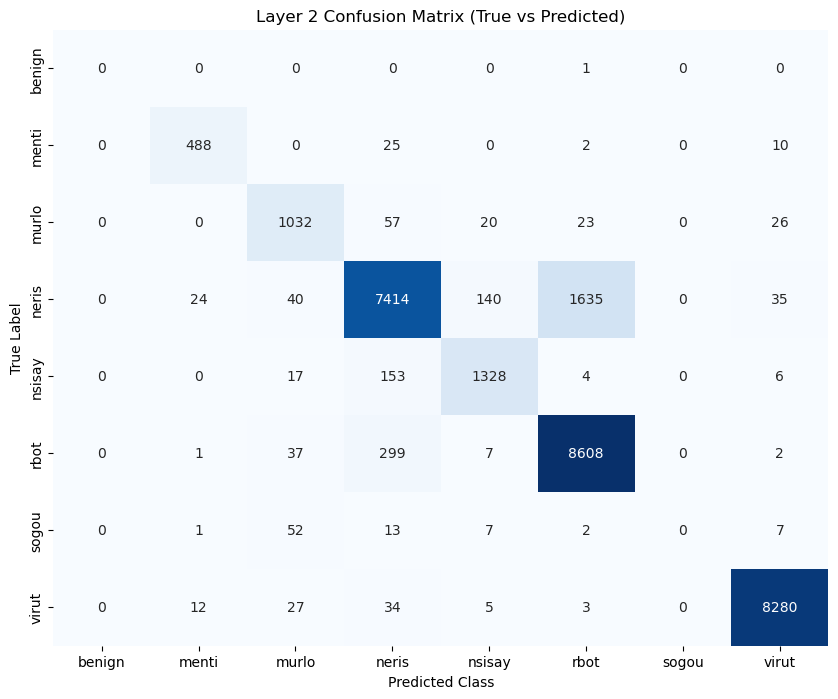


Detailed Classification Report:
              precision    recall  f1-score   support

      benign       0.00      0.00      0.00         1
       menti       0.93      0.93      0.93       525
       murlo       0.86      0.89      0.87      1158
       neris       0.93      0.80      0.86      9288
      nsisay       0.88      0.88      0.88      1508
        rbot       0.84      0.96      0.90      8954
       sogou       0.00      0.00      0.00        82
       virut       0.99      0.99      0.99      8361

    accuracy                           0.91     29877
   macro avg       0.68      0.68      0.68     29877
weighted avg       0.91      0.91      0.91     29877

neris     9288
rbot      8954
virut     8361
nsisay    1508
murlo     1158
menti      525
sogou       82
benign       1
Name: label, dtype: int64


In [ ]:
df_new=pd.concat([test_layer_1, test_2,test_new],ignore_index=True)
def testing_new(df):
    attack_df_layer1 = detect_attacks_layer1(df, vae_layer1, scaler_layer1, threshold=0.2)
    print(attack_df_layer1['label'].value_counts())
    df_test_layer_3 = predict_2(rf_new, label_encoder_new, attack_df_layer1,['B'])
    print(df_test_layer_3['label'].value_counts())
    # zero_day_count = layer4_zero_day_detection(
    # df_test_layer_3, vae_model_6, scalers_layer6
# )
testing_new(df_new)


d:\anaconda-python\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


🔍 LAYER 2 BOTNET DETECTION — METRICS SUMMARY

📊 Confusion Matrix:
            Pred_neris  Pred_rbot  Pred_other
True_neris        8388        753         147
True_rbot          180       8719          55
True_other          20         28       11504

📌 Overall Accuracy: 0.9603

--- CLASS-WISE METRICS ---

Class: neris
 Precision: 0.9767
 Recall (Detection Rate): 0.9031
 F1-Score: 0.9385

Class: rbot
 Precision: 0.9178
 Recall (Detection Rate): 0.9738
 F1-Score: 0.9449

Class: other
 Precision: 0.9827
 Recall (Detection Rate): 0.9958
 F1-Score: 0.9893

📌 Macro F1: 0.9576
📌 Weighted F1: 0.9601

--- BOTNET-SPECIFIC METRICS ---
🔸 Detection Rate (Neris): 0.9031
🔸 Detection Rate (Rbot): 0.9738
🔸 False Alarm Rate (FAR): 0.0042


d:\anaconda-python\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


🔍 LAYER 2 BOTNET DETECTION — METRICS SUMMARY

📊 Confusion Matrix:
            Pred_neris  Pred_rbot  Pred_other
True_neris        8537        673          78
True_rbot          200       8722          32
True_other          25          8       11519

📌 Overall Accuracy: 0.9659

--- CLASS-WISE METRICS ---

Class: neris
 Precision: 0.9743
 Recall (Detection Rate): 0.9191
 F1-Score: 0.9459

Class: rbot
 Precision: 0.9276
 Recall (Detection Rate): 0.9741
 F1-Score: 0.9503

Class: other
 Precision: 0.9905
 Recall (Detection Rate): 0.9971
 F1-Score: 0.9938

📌 Macro F1: 0.9633
📌 Weighted F1: 0.9658

--- BOTNET-SPECIFIC METRICS ---
🔸 Detection Rate (Neris): 0.9191
🔸 Detection Rate (Rbot): 0.9741
🔸 False Alarm Rate (FAR): 0.0029

=== LAYER 3 PERFORMANCE SUMMARY ===
Accuracy: 97.36%
Total samples: 11552
Correct predictions: 11247
Incorrect predictions: 305

Confusion Matrix:
        menti  murlo  nsisay  virut
menti     504      0       0     21
murlo       0   1071      46     42
nsisay      0 

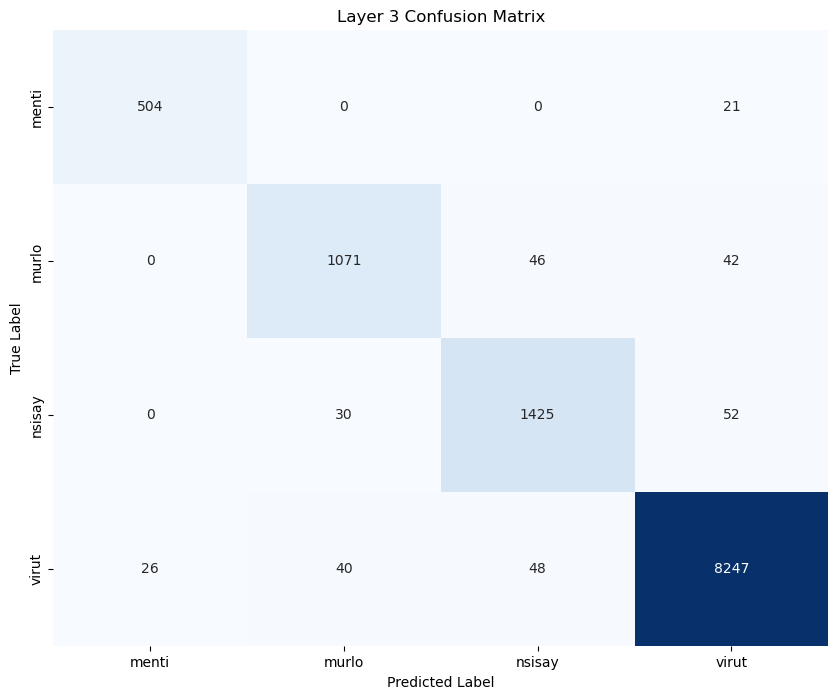


=== LAYER 3 PERFORMANCE SUMMARY ===
Accuracy: 99.51%
Total samples: 11552
Correct predictions: 11495
Incorrect predictions: 57

Confusion Matrix:
        menti  murlo  nsisay  virut
menti     525      0       0      0
murlo       0   1133       4     22
nsisay      0      2    1504      1
virut       0     25       3   8333


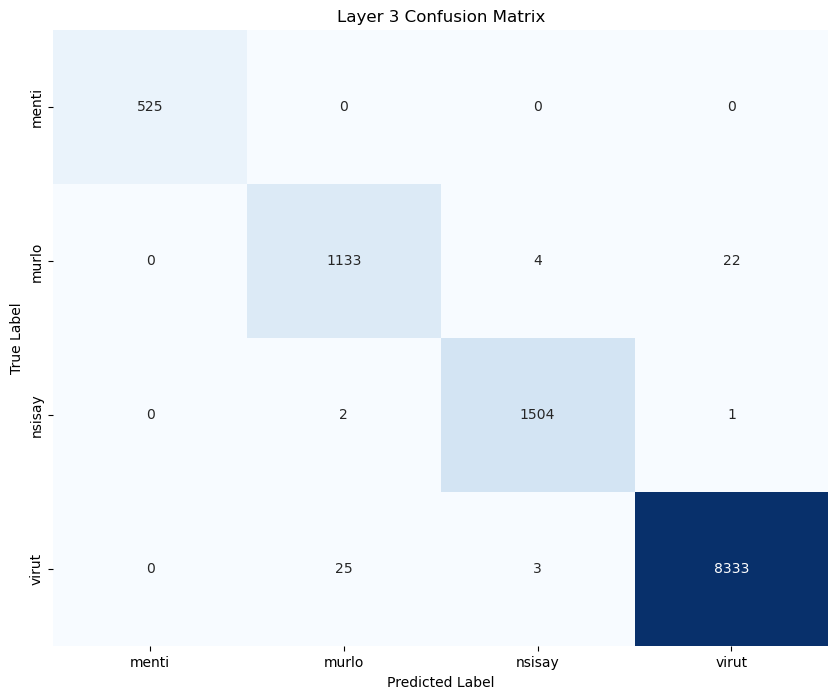

,Flow Duration,Flow Byts/s,Flow Pkts/s,Fwd Pkts/s,Bwd Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Mean,...,RST Flag Cnt,PSH Flag Cnt,FIN Flag Cnt,Pkt Len Max,Pkt Len Min,Fwd Header Len,Bwd Header Len,Down/Up Ratio,label,Predicted_Class
4062,1.263817e+07,0.0,0.180751,0.131455,0.049296,1.376636e+06,1.340024e+06,7401802.125,7.0,456211.00,...,0,0,0,0.0,0.0,140,76,0.0,murlo,murlo
32727,7.007981e+06,0.0,0.665685,0.554738,0.110948,6.211086e+05,1.067762e+06,6008665.000,9.0,338917.00,...,0,0,0,0.0,0.0,140,28,0.0,virut,virut
25129,1.307765e+06,0.0,6.881970,3.823317,3.058654,1.634706e+05,1.807879e+05,454577.000,9.0,290362.50,...,0,0,0,0.0,0.0,140,88,0.0,virut,virut
42885,1.307976e+06,0.0,6.880860,3.822700,3.058160,1.634970e+05,1.808524e+05,454404.000,9.0,290454.75,...,0,0,0,0.0,0.0,140,88,0.0,virut,virut
13607,6.188290e+05,0.0,4.847866,0.000000,4.847866,3.094145e+05,4.375598e+05,618816.000,13.0,143427.00,...,0,0,0,0.0,0.0,140,24,0.0,nsisay,nsisay
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22863,1.242164e+06,0.0,12.442558,8.719483,5.806152,2.823100e+04,5.068810e+04,179102.000,7.5,260721.00,...,0,0,0,0.0,0.0,140,178,0.0,virut,virut
6607,4.211210e+05,0.0,7.123843,4.749229,2.374614,2.105605e+05,2.162481e+05,363471.000,13.0,143427.00,...,0,0,0,0.0,0.0,140,8,0.0,murlo,murlo
45737,1.307389e+06,0.0,6.883950,3.824416,3.059533,1.634236e+05,1.806863e+05,454522.000,10.0,290250.25,...,0,0,0,0.0,0.0,140,88,0.0,virut,virut
17837,1.649410e+05,0.0,12.125548,0.000000,12.125548,1.649410e+05,0.000000e+00,164941.000,13.0,143427.00,...,0,0,0,0.0,0.0,140,40,0.0,virut,virut


In [ ]:
# df_test_1 = pd.concat([test_layer_1, test_layer_2], ignore_index=True)
df_test = pd.concat([test_layer_1, test_layer_2,test_new], ignore_index=True)
predict_layer2_model(layer2_model_A, scaler_layer_2_A,label_encoder_layer2_A,test_layer_2,['A'])
predict_layer2_model(layer2_model_AB, scaler_layer_2_AB,label_encoder_layer2_AB,test_layer_2,['A','B'])
predict_layer3_simple(rf_layer3_B, label_encoder_layer3_B, test_layer_3,['B'])
predict_layer3_simple(rf_layer3_AB, label_encoder_layer3_AB, test_layer_3,['A','B'])

# def testing(df):
#     attack_df_layer1 = detect_attacks_layer1(df, vae_layer1, scaler_layer1, threshold=0.2)
#     # print(attack_df_layer1['label'].value_counts())
#     df_test_layer_3 = predict_layer2_model(layer2_model_A, scaler_layer_2_A,label_encoder_layer2_A, attack_df_layer1,['A'])
#     # print(df_test_layer_3['label'].value_counts())
#     layer3_results,accuracy = predict_layer3_simple(rf_layer3_B, label_encoder_layer3_B, df_test_layer_3)
#     print(layer3_results['label'].value_counts())
#     zero_day_count= layer4_zero_day_detection(
#     layer3_results, vae_models, scalers_layer4
# )
# testing(df_test)

1258/1258 ━━━━━━━━━━━━━━━━━━━━ 1s 706us/step

CONFUSION MATRIX (rows=true, cols=pred):
[[10376     1]
 [    0 29876]]

Accuracy : 0.999975
Precision: 0.999967
Recall   : 1.000000
F1-Score : 0.999983
ROC-AUC  : 1.000000
neris     9288
rbot      8954
virut     8415
nsisay    1492
murlo     1125
menti      520
sogou       82
benign       1
Name: label, dtype: int64


d:\anaconda-python\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


🔍 LAYER 2 BOTNET DETECTION — METRICS SUMMARY

📊 Confusion Matrix:
            Pred_neris  Pred_rbot  Pred_other
True_neris        8537        673          78
True_rbot          200       8722          32
True_other          40         22       11573

📌 Overall Accuracy: 0.965

--- CLASS-WISE METRICS ---

Class: neris
 Precision: 0.9727
 Recall (Detection Rate): 0.9191
 F1-Score: 0.9451

Class: rbot
 Precision: 0.9262
 Recall (Detection Rate): 0.9741
 F1-Score: 0.9495

Class: other
 Precision: 0.9906
 Recall (Detection Rate): 0.9947
 F1-Score: 0.9926

📌 Macro F1: 0.9624
📌 Weighted F1: 0.965

--- BOTNET-SPECIFIC METRICS ---
🔸 Detection Rate (Neris): 0.9191
🔸 Detection Rate (Rbot): 0.9741
🔸 False Alarm Rate (FAR): 0.0053
virut     8415
nsisay    1480
murlo     1104
menti      520
neris       78
sogou       54
rbot        32
Name: label, dtype: int64

=== LAYER 3 PERFORMANCE SUMMARY ===
Accuracy: 98.22%
Total samples: 11683
Correct predictions: 11475
Incorrect predictions: 208

Confusion M

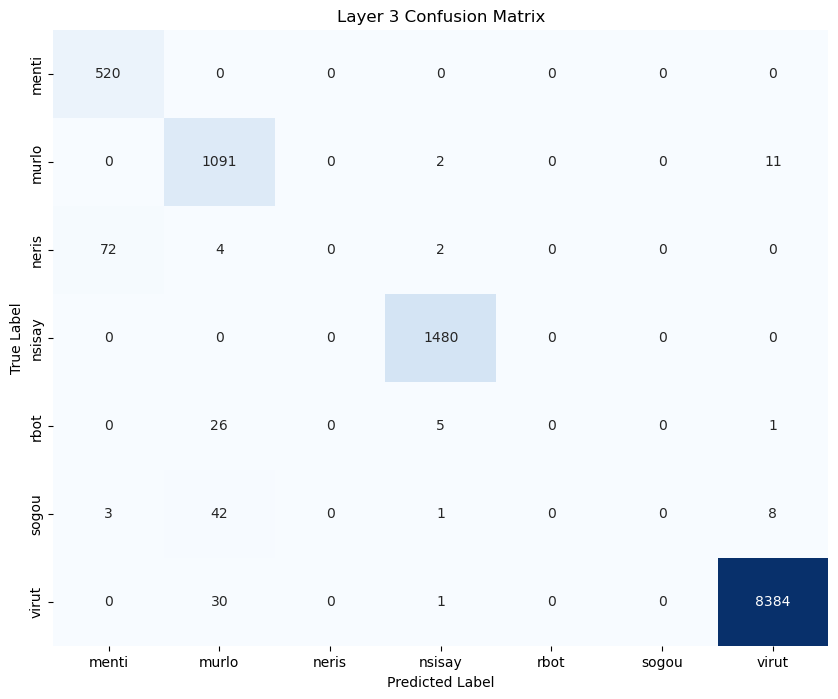

NameError: name 'layer4_zero_day_detection' is not defined

In [ ]:
def testing(df):
    attack_df_layer1 = detect_attacks_layer1(df, vae_layer1, scaler_layer1, threshold=0.2)
    print(attack_df_layer1['label'].value_counts())
    df_test_layer_3 = predict_layer2_model(layer2_model_AB, scaler_layer_2_AB,label_encoder_layer2_AB, attack_df_layer1,['A','B'])
    print(df_test_layer_3['label'].value_counts())
    layer3_results= predict_layer3_simple(rf_layer3_AB, label_encoder_layer3_AB, df_test_layer_3,['A','B'])
    # print(layer3_results['label'].value_counts())
    zero_day_count= layer4_zero_day_detection(
    layer3_results, vae_models, scalers_layer4
)
testing(df_test)

1258/1258 ━━━━━━━━━━━━━━━━━━━━ 1s 597us/step

CONFUSION MATRIX (rows=true, cols=pred):
[[10376     1]
 [    0 29876]]

Accuracy : 0.999975
Precision: 0.999967
Recall   : 1.000000
F1-Score : 0.999983
ROC-AUC  : 1.000000
neris     9288
rbot      8954
virut     8415
nsisay    1492
murlo     1125
menti      520
sogou       82
benign       1
Name: label, dtype: int64


d:\anaconda-python\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


🔍 LAYER 2 BOTNET DETECTION — METRICS SUMMARY

📊 Confusion Matrix:
            Pred_neris  Pred_rbot  Pred_other
True_neris        8537        673          78
True_rbot          200       8722          32
True_other          40         22       11573

📌 Overall Accuracy: 0.965

--- CLASS-WISE METRICS ---

Class: neris
 Precision: 0.9727
 Recall (Detection Rate): 0.9191
 F1-Score: 0.9451

Class: rbot
 Precision: 0.9262
 Recall (Detection Rate): 0.9741
 F1-Score: 0.9495

Class: other
 Precision: 0.9906
 Recall (Detection Rate): 0.9947
 F1-Score: 0.9926

📌 Macro F1: 0.9624
📌 Weighted F1: 0.965

--- BOTNET-SPECIFIC METRICS ---
🔸 Detection Rate (Neris): 0.9191
🔸 Detection Rate (Rbot): 0.9741
🔸 False Alarm Rate (FAR): 0.0053
virut     8415
nsisay    1480
murlo     1104
menti      520
neris       78
sogou       54
rbot        32
Name: label, dtype: int64

=== LAYER 3 PERFORMANCE SUMMARY ===
Accuracy: 97.08%
Total samples: 11683
Correct predictions: 11342
Incorrect predictions: 341

Confusion M

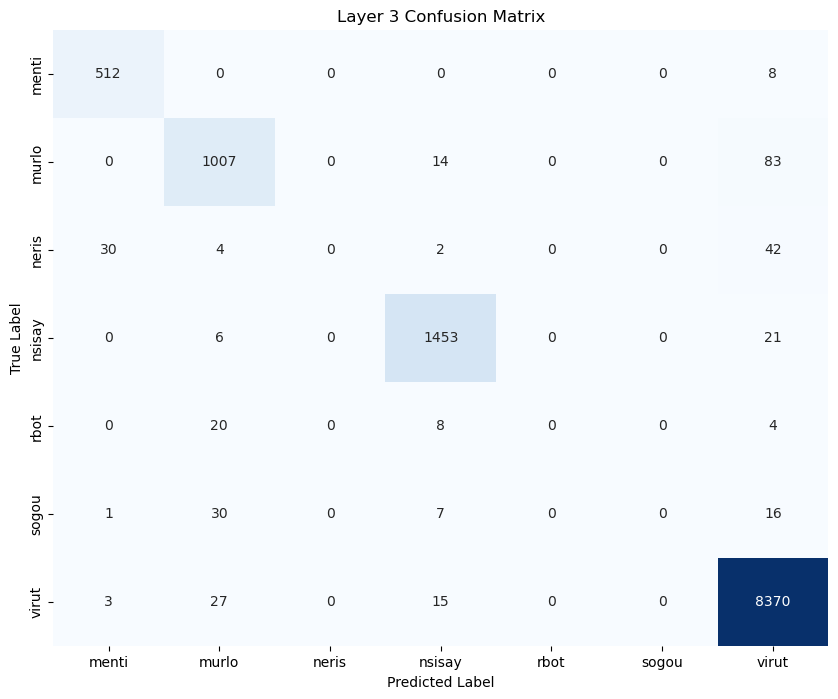

In [ ]:
def testing(df):
    attack_df_layer1 = detect_attacks_layer1(df, vae_layer1, scaler_layer1, threshold=0.2)
    print(attack_df_layer1['label'].value_counts())
    df_test_layer_3 = predict_layer2_model(layer2_model_AB, scaler_layer_2_AB,label_encoder_layer2_AB, attack_df_layer1,['A','B'])
    print(df_test_layer_3['label'].value_counts())
    layer3_results= predict_layer3_simple(rf_layer3_B, label_encoder_layer3_B, df_test_layer_3,['B'])
    # print(layer3_results['label'].value_counts())
#     zero_day_count= layer4_zero_day_detection(
#     layer3_results, vae_models, scalers_layer4
# )
testing(df_test)

1258/1258 ━━━━━━━━━━━━━━━━━━━━ 1s 677us/step
LAYER 1 DETECTION ANALYSIS
✓ DETECTION SUMMARY:
  - Total samples: 40253
  - Detected as attacks: 29879 (74.23%)
  - Detected as benign: 10374 (25.77%)
  - Threshold used: 0.2

✓ GROUND TRUTH DISTRIBUTION:
  - Actual benign samples: 10377 (25.78%)
  - Actual attack samples: 29876 (74.22%)

✓ DETECTION PERFORMANCE:
  - True Positives (correct attacks): 29876/29876 (100.00%)
  - False Positives (benign as attacks): 3/10377 (0.03%)
  - True Negatives (correct benign): 10374/10377 (99.97%)
  - False Negatives (missed attacks): 0/29876 (0.00%)

✓ PERFORMANCE METRICS:
  - Accuracy: 99.99%
  - Precision: 99.99%
  - Recall: 100.00%
  - F1-Score: 99.99%

✓ DETECTED ATTACKS BREAKDOWN:
  • neris: 9288 samples (31.1%)
  • rbot: 8954 samples (30.0%)
  • virut: 8415 samples (28.2%)
  • nsisay: 1492 samples (5.0%)
  • murlo: 1125 samples (3.8%)
  • menti: 520 samples (1.7%)
  • sogou: 82 samples (0.3%)
  • benign: 3 samples (0.0%)

✓ RECONSTRUCTION ERROR S

d:\anaconda-python\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


LAYER 2 PREDICTION ANALYSIS
✓ Overall Accuracy (argmax): 95.93%
✓ Mean Confidence: 0.964
✓ Mean Entropy: 0.094

📊 Confusion Matrix (Argmax Predictions):
            Pred_neris  Pred_rbot  Pred_other
True_neris        8424        743         121
True_rbot          182       8678          94
True_other          60         15       11562


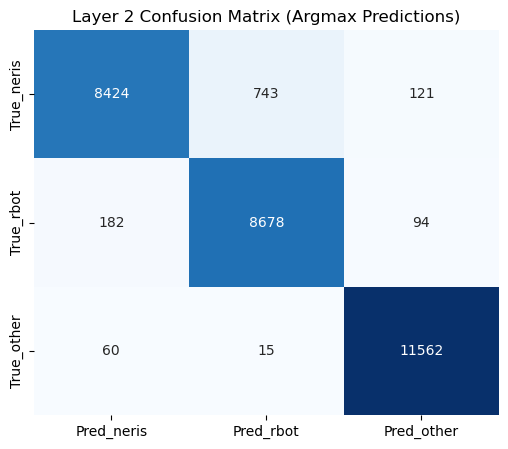


🔍 DETAILED ROUTING BREAKDOWN:
Total samples: 29879
Retained: 18074 (60.5%)
Routed: 11805 (39.5%)

📊 Individual Routing Conditions:
  - Predicted as 'other': 11777
  - Low confidence (<0.5): 79
  - High entropy (>0.9): 117

📊 Exclusive Cases (only one condition):
  - Only predicted as 'other': 11687
  - Only low confidence: 1
  - Only high entropy: 10

📊 Overlapping Cases (multiple conditions):
  - Low confidence + High entropy: 17
  - Low confidence + 'other': 0
  - High entropy + 'other': 29
  - All three conditions: 61

✅ Routing breakdown validation: 11805 == 11805 ✓

📊 Confusion Matrix (After Entropy/Confidence Routing):
            Pred_neris  Pred_rbot  Pred_other
True_neris        8423        737         128
True_rbot          181       8660         113
True_other          60         13       11564


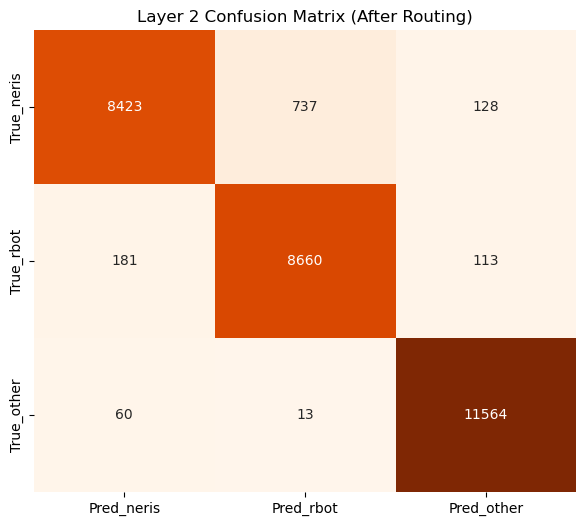

virut     8411
nsisay    1484
murlo     1093
menti      505
neris      128
rbot       113
sogou       70
benign       1
Name: label, dtype: int64

=== LAYER 3 PERFORMANCE SUMMARY ===
Accuracy: 95.87%
Total samples: 11805
Correct predictions: 11318
Incorrect predictions: 487

Confusion Matrix:
        benign  menti  murlo  neris  nsisay  rbot  sogou  virut
benign       0      0      0      0       0     0      0      1
menti        0    499      0      0       0     0      0      6
murlo        0      0    997      0      15     0      0     81
neris        0     22     55      0      21     0      0     30
nsisay       0      0      6      0    1455     0      0     23
rbot         0      3     61      0      12     0      0     37
sogou        0      1     33      0      12     0      0     24
virut        0      3     27      0      14     0      0   8367


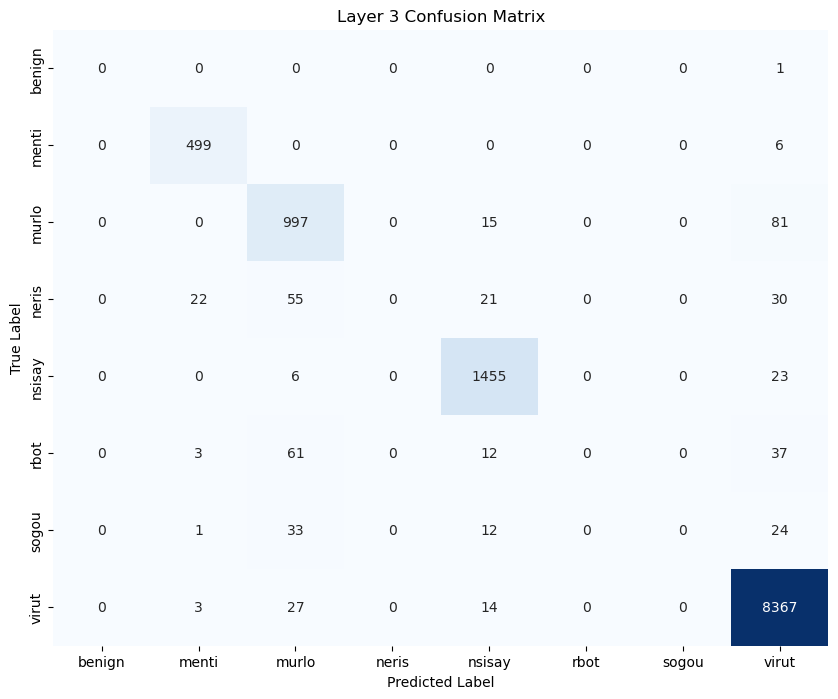


Detailed Classification Report:
              precision    recall  f1-score   support

      benign       0.00      0.00      0.00         1
       menti       0.95      0.99      0.97       505
       murlo       0.85      0.91      0.88      1093
       neris       0.00      0.00      0.00       128
      nsisay       0.95      0.98      0.97      1484
        rbot       0.00      0.00      0.00       113
       sogou       0.00      0.00      0.00        70
       virut       0.98      0.99      0.99      8411

    accuracy                           0.96     11805
   macro avg       0.46      0.48      0.47     11805
weighted avg       0.93      0.96      0.95     11805


=== Breakdown of True Labels for Each Predicted Class ===

▶ Predicted as 'menti':
True
menti    499
neris     22
rbot       3
virut      3
sogou      1
Name: menti, dtype: int64

▶ Predicted as 'murlo':
True
murlo     997
rbot       61
neris      55
sogou      33
virut      27
nsisay      6
Name: murlo, dtype: in

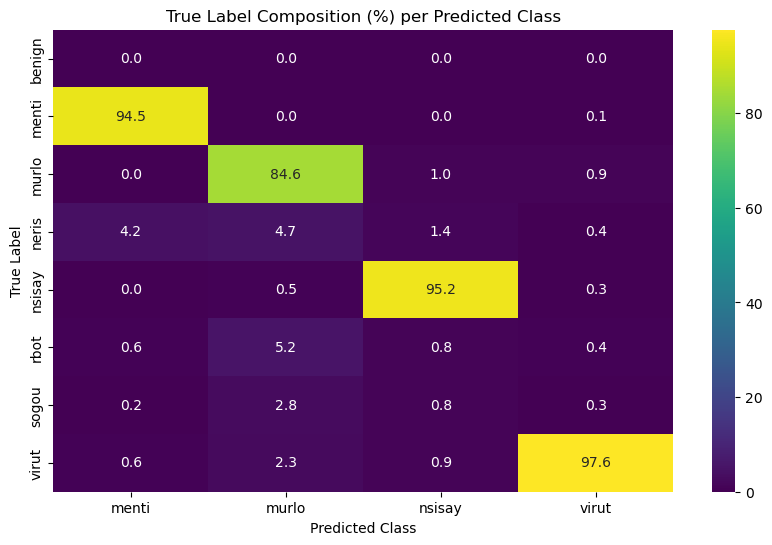

virut     8411
nsisay    1484
murlo     1093
menti      505
neris      128
rbot       113
sogou       70
benign       1
Name: label, dtype: int64
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step

d:\anaconda-python\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
d:\anaconda-python\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
  1/268 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step

d:\anaconda-python\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
d:\anaconda-python\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
Sogou zero-day count: 70
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step
LAYER 1 DETECTION ANALYSIS
✓ DETECTION SUMMARY:
  - Total samples: 40171
  - Detected as attacks: 29797 (74.18%)
  - Detected as benign: 10374 (25.82%)
  - Threshold used: 0.2

✓ GROUND TRUTH DISTRIBUTION:
  - Actual benign samples: 10377 (25.83%)
  - Actual attack samples: 29794 (74.17%)

✓ DETECTION PERFORMANCE:
  - True Positives (correct attacks): 29794/29794 (100.00%)
  - False Positives (benign as attacks): 3/10377 (0.03%)
  - True Negatives (correct benign): 10374/10377 (99.97%)
  - False Negatives (missed attacks): 0/29794 (0.00%)

✓ PERFORMANCE METRICS:
  - Accuracy: 99.99%
  - Precision: 99.99%
  - Recall: 100.00%
  - F1-Score: 99.99%

✓ DETECTED ATTACKS BREAKDOWN:
  • neris: 9288 samples (31.2%)
  • rbot: 8954 samples (30.1%)
  • virut: 8415 samples (28.2%)
  • nsisay: 1492 samples (5.0%)
  • murlo: 1125 samples (3.8%)
  • menti: 520 samples (1.7%)
  • benign: 3 s

d:\anaconda-python\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


LAYER 2 PREDICTION ANALYSIS
✓ Overall Accuracy (argmax): 95.96%
✓ Mean Confidence: 0.964
✓ Mean Entropy: 0.095

📊 Confusion Matrix (Argmax Predictions):
            Pred_neris  Pred_rbot  Pred_other
True_neris        8424        743         121
True_rbot          182       8678          94
True_other          50         13       11492


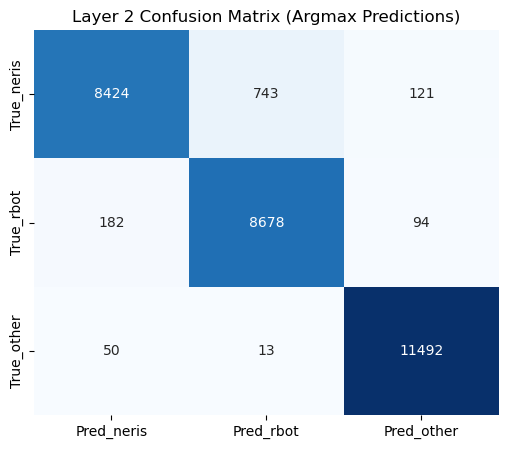


🔍 DETAILED ROUTING BREAKDOWN:
Total samples: 29797
Retained: 18062 (60.6%)
Routed: 11735 (39.4%)

📊 Individual Routing Conditions:
  - Predicted as 'other': 11707
  - Low confidence (<0.5): 79
  - High entropy (>0.9): 117

📊 Exclusive Cases (only one condition):
  - Only predicted as 'other': 11617
  - Only low confidence: 1
  - Only high entropy: 10

📊 Overlapping Cases (multiple conditions):
  - Low confidence + High entropy: 17
  - Low confidence + 'other': 0
  - High entropy + 'other': 29
  - All three conditions: 61

✅ Routing breakdown validation: 11735 == 11735 ✓

📊 Confusion Matrix (After Entropy/Confidence Routing):
            Pred_neris  Pred_rbot  Pred_other
True_neris        8423        737         128
True_rbot          181       8660         113
True_other          50         11       11494


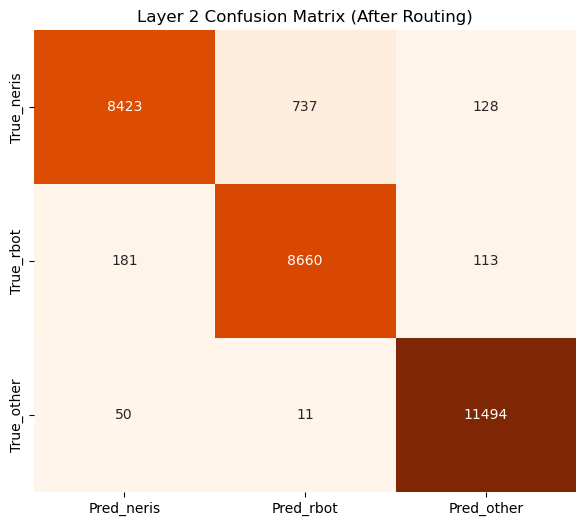

virut     8411
nsisay    1484
murlo     1093
menti      505
neris      128
rbot       113
benign       1
Name: label, dtype: int64

=== LAYER 3 PERFORMANCE SUMMARY ===
Accuracy: 96.45%
Total samples: 11735
Correct predictions: 11318
Incorrect predictions: 417

Confusion Matrix:
        benign  menti  murlo  neris  nsisay  rbot  virut
benign       0      0      0      0       0     0      1
menti        0    499      0      0       0     0      6
murlo        0      0    997      0      15     0     81
neris        0     22     55      0      21     0     30
nsisay       0      0      6      0    1455     0     23
rbot         0      3     61      0      12     0     37
virut        0      3     27      0      14     0   8367


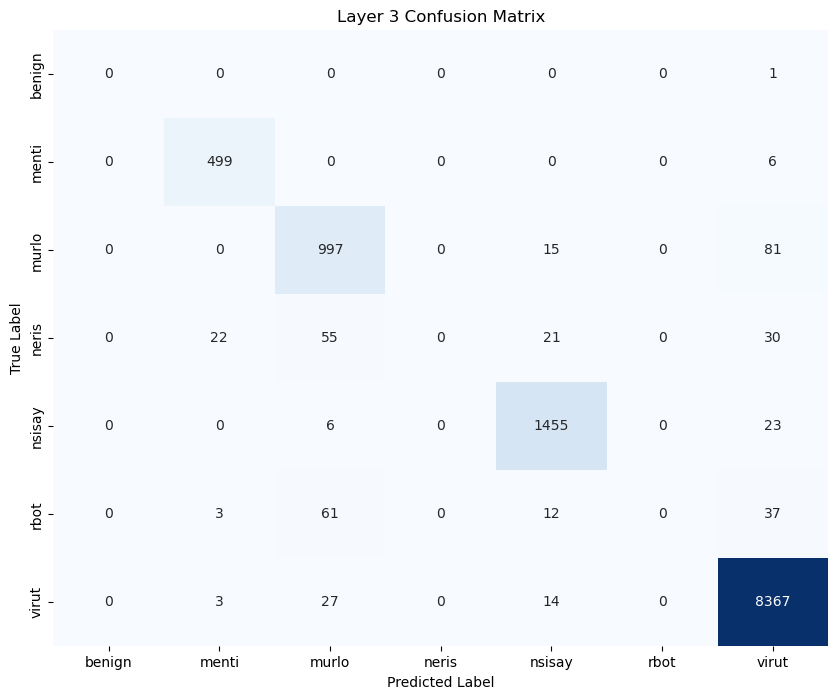


Detailed Classification Report:
              precision    recall  f1-score   support

      benign       0.00      0.00      0.00         1
       menti       0.95      0.99      0.97       505
       murlo       0.87      0.91      0.89      1093
       neris       0.00      0.00      0.00       128
      nsisay       0.96      0.98      0.97      1484
        rbot       0.00      0.00      0.00       113
       virut       0.98      0.99      0.99      8411

    accuracy                           0.96     11735
   macro avg       0.54      0.55      0.54     11735
weighted avg       0.94      0.96      0.95     11735


=== Breakdown of True Labels for Each Predicted Class ===

▶ Predicted as 'menti':
True
menti    499
neris     22
rbot       3
virut      3
Name: menti, dtype: int64

▶ Predicted as 'murlo':
True
murlo     997
rbot       61
neris      55
virut      27
nsisay      6
Name: murlo, dtype: int64

▶ Predicted as 'nsisay':
True
nsisay    1455
neris       21
murlo       15
v

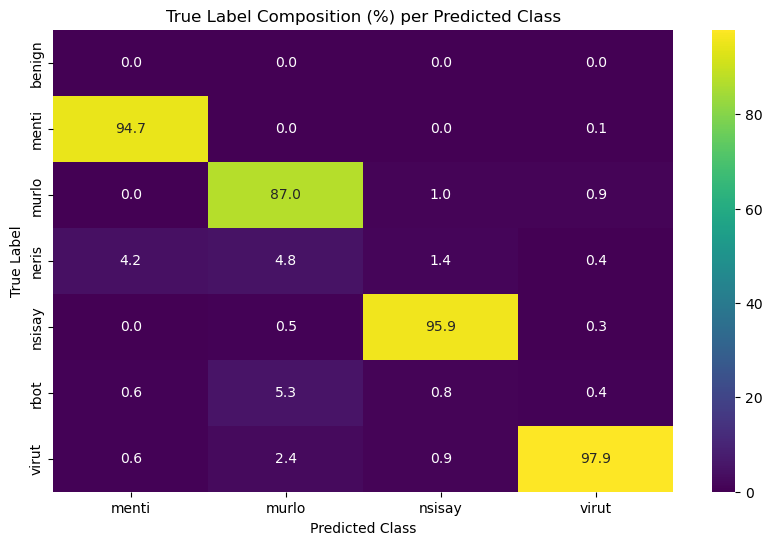

virut     8411
nsisay    1484
murlo     1093
menti      505
neris      128
rbot       113
benign       1
Name: label, dtype: int64
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


d:\anaconda-python\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
d:\anaconda-python\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
d:\anaconda-python\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
140/268 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step

d:\anaconda-python\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
Sogou zero-day count: 0


In [ ]:
def testing(df):
    attack_df_layer1, mae_scores = detect_attacks_layer1(df, vae_layer1, scaler_layer1, threshold=0.2)
    print(attack_df_layer1['label'].value_counts())
    df_test_layer_3, pred,acc = predict_layer2_model(layer2_model, scaler_layer_2,label_encoder_layer2, attack_df_layer1)
    print(df_test_layer_3['label'].value_counts())
    layer3_results,accuracy = predict_layer3_simple(rf_layer3, label_encoder_layer3, df_test_layer_3)
    print(layer3_results['label'].value_counts())
    zero_day_count= layer4_zero_day_detection(
    layer3_results, vae_models, scalers_layer4
)
testing(df_test)
testing(df_test_1)

1258/1258 ━━━━━━━━━━━━━━━━━━━━ 1s 675us/step
LAYER 1 DETECTION ANALYSIS
✓ DETECTION SUMMARY:
  - Total samples: 40253
  - Detected as attacks: 29880 (74.23%)
  - Detected as benign: 10373 (25.77%)
  - Threshold used: 0.2

✓ GROUND TRUTH DISTRIBUTION:
  - Actual benign samples: 10377 (25.78%)
  - Actual attack samples: 29876 (74.22%)

✓ DETECTION PERFORMANCE:
  - True Positives (correct attacks): 29876/29876 (100.00%)
  - False Positives (benign as attacks): 4/10377 (0.04%)
  - True Negatives (correct benign): 10373/10377 (99.96%)
  - False Negatives (missed attacks): 0/29876 (0.00%)

✓ PERFORMANCE METRICS:
  - Accuracy: 99.99%
  - Precision: 99.99%
  - Recall: 100.00%
  - F1-Score: 99.99%

✓ DETECTED ATTACKS BREAKDOWN:
  • neris: 9288 samples (31.1%)
  • rbot: 8954 samples (30.0%)
  • virut: 8415 samples (28.2%)
  • nsisay: 1492 samples (5.0%)
  • murlo: 1125 samples (3.8%)
  • menti: 520 samples (1.7%)
  • sogou: 82 samples (0.3%)
  • benign: 4 samples (0.0%)
neris     9288
rbot      

d:\anaconda-python\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


LAYER 2 PREDICTION ANALYSIS
✓ Overall Accuracy (argmax): 96.12%
✓ Mean Confidence: 0.959
✓ Mean Entropy: 0.107

📊 Confusion Matrix (Argmax Predictions):
            Pred_neris  Pred_rbot  Pred_other
True_neris        8381        808          99
True_rbot          118       8794          42
True_other          82          9       11547


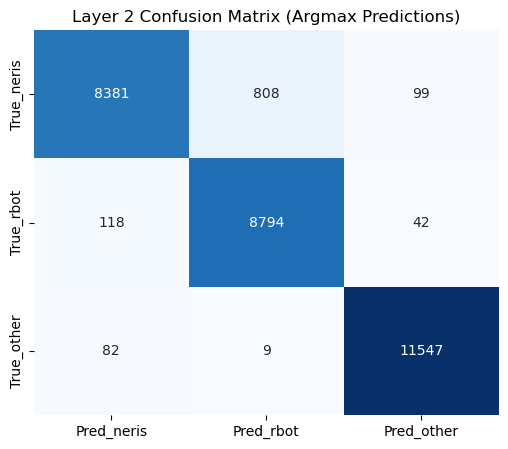

virut     8412
nsisay    1485
murlo     1108
menti      520
neris       99
rbot        42
sogou       22
Name: label, dtype: int64


NameError: name 'predict_layer3_simple' is not defined

In [ ]:
def testing(df):
    attack_df_layer1, mae_scores = detect_attacks_layer1(df, vae_layer1, scaler_layer1, threshold=0.2)
    print(attack_df_layer1['label'].value_counts())
    df_test_layer_3, pred,acc = predict_layer2_model(layer2_model, scaler_layer_2,label_encoder_layer2, attack_df_layer1)
    print(df_test_layer_3['label'].value_counts())
    layer3_results,accuracy = predict_layer3_simple(rf_layer3, label_encoder_layer3, df_test_layer_3)
    print(layer3_results['label'].value_counts())
    zero_day_count= layer4_zero_day_detection(
    layer3_results, vae_models, scalers_layer4
)
testing(df_test)
testing(df_test_1)